<a href="https://colab.research.google.com/github/ashikshafi08/AICrowd_Competition_Files/blob/main/blitz_faces/AICrowd_Age_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the env ready! 

**Note:** This notebook is work in progress, making the baseline aka working model at first place. 

In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

%aicrowd login

!rm -rf data
!mkdir data
%aicrowd ds dl -c age-prediction -o data

!unzip data/train.zip -d data/train 
!unzip data/val.zip -d data/val 
!unzip data/test.zip -d data/test 

In [9]:
# Loading the data

import pandas as pd
import numpy as np
import os

# Image path 
train_img_path = 'data/train/'
val_img_path = 'data/val/'
test_img_path = 'data/test/'

train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv('data/test.csv')

train_df.head()

,ImageID,age
0,93vu1,30-40
1,yjifi,80-90
2,ldd2k,90-100
3,eiwe0,40-50
4,sc0bp,0-10


In [10]:
# Creating a function for making the action
def append_ext(fn , ext):
    return f'{ext}{fn}.jpg'

# Now applying them 
train_df['fullpath'] = train_df['ImageID'].apply(lambda x: append_ext(x , ext = 'data/train/'))
val_df['fullpath'] = val_df['ImageID'].apply(lambda x: append_ext(x , ext = 'data/val/'))
test_df['fullpath'] = test_df['ImageID'].apply(lambda x: append_ext(x , ext = 'data/test/'))

train_df.head()

,ImageID,age,fullpath
0,93vu1,30-40,data/train/93vu1.jpg
1,yjifi,80-90,data/train/yjifi.jpg
2,ldd2k,90-100,data/train/ldd2k.jpg
3,eiwe0,40-50,data/train/eiwe0.jpg
4,sc0bp,0-10,data/train/sc0bp.jpg


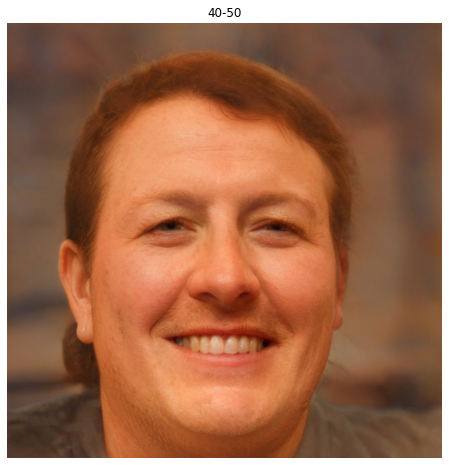

In [23]:
# Displaying random images of pets 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 
from matplotlib.pyplot import figure 


random_index = random.randrange(len(train_df['fullpath'].tolist())) 

train_fns = train_df['fullpath'].tolist()
train_labels = train_df['age'].to_list()


random_filename = train_fns[random_index]
random_label = train_labels[random_index]

# Plotting the image 
im = mpimg.imread(random_filename)
figure(figsize = (10 , 8))
plt.imshow(im)
plt.title(random_label)
plt.axis('off');


## Model baby!

In [27]:
# For data augmentation and loading in the filepath
import tensorflow as tf 
from tensorflow.keras import layers

# For augmenting datta -> using layers casuses problems
def augment_data(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_saturation(img , 0.95 , 1.05)
    img = tf.image.random_brightness(img , 0.5)
    img = tf.image.random_contrast(img , 0.95 , 1.05)
    img = tf.image.random_hue(img , 0.05)
    
    return img



# Get the image data 
def load_img(file_path , label):
  im = tf.io.read_file(file_path)
  im = tf.image.decode_jpeg(im , channels = 3)
  im = tf.image.convert_image_dtype(im , tf.float32)
  im = tf.image.resize(im , size = (224 , 224))
 # im = im / 255. # turns the whole image into black
  im = augment_data(im)
  return im , label

In [28]:
# Getting the file paths and labels in a list 
train_fns = train_df['fullpath'].tolist()
train_labels = train_df['age'].tolist()

val_fns = val_df['fullpath'].tolist()
val_labels = val_df['age'].tolist()

test_fns = test_df['fullpath'].tolist()
test_labels = test_df['age'].tolist()

In [29]:
load_img(train_fns[0] , train_labels[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 0.19069436,  0.03706799, -0.0491011 ],
         [ 0.1790142 ,  0.0253879 , -0.06078119],
         [ 0.1745449 ,  0.0203973 , -0.07332132],
         ...,
         [ 0.287747  ,  0.12019021,  0.01970388],
         [ 0.27290866,  0.11420447,  0.01697172],
         [ 0.26549956,  0.10679539,  0.00956264]],
 
        [[ 0.1827287 ,  0.02910237, -0.05706671],
         [ 0.18098046,  0.02735416, -0.05881492],
         [ 0.17706738,  0.02291978, -0.07079884],
         ...,
         [ 0.29136187,  0.12380514,  0.02331883],
         [ 0.28218502,  0.12295966,  0.0181773 ],
         [ 0.28051645,  0.12181226,  0.0245795 ]],
 
        [[ 0.17764345,  0.02390544, -0.06388123],
         [ 0.17728591,  0.02313837, -0.07058025],
         [ 0.17800097,  0.0228771 , -0.0715945 ],
         ...,
         [ 0.30359787,  0.13738571,  0.03246656],
         [ 0.28802475,  0.12868771,  0.02228777],
         [ 0.29217634,  0.13295099,  0.0281686

In [33]:
# Building a tf data dataset 

train_dataset = tf.data.Dataset.from_tensor_slices((train_fns , train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_fns , test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_fns , val_labels))

train_ds = train_dataset.map(map_func= load_img , num_parallel_calls = tf.data.AUTOTUNE)
val_ds = val_dataset.map(map_func = load_img , num_parallel_calls = tf.data.AUTOTUNE)
test_ds = test_dataset.map(load_img, num_parallel_calls = tf.data.AUTOTUNE)

train_ds 


<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.string)>